In [22]:
import asyncio
from ib_insync import *
import pandas as pd
import numpy as np
from filterpy.kalman import KalmanFilter
from scipy.stats import norm
from scipy.optimize import brentq
import pandas_datareader.data as web
import datetime

# --- PARAMETERS ---
numbars = 20
durationStr = '7 D'
barSizeSetting = '1 min'

# Leg 1
symbol1 = 'TSLA'
lastTradeDateOrContractMonth1 = '20250718'
strike1 = 310
right1 = 'P'

# Leg 2
symbol2 = 'TSLA'
lastTradeDateOrContractMonth2 = '20250718'
strike2 = 300
right2 = 'P'

# --- FETCH FUNCTION ---
async def fetch_option(symbol, lastTradeDateOrContractMonth, strike, right, num_bars):
    ib = IB()
    await ib.connectAsync('127.0.0.1', 7496, clientId=np.random.randint(1000, 10000))

    option_contract = Option(
        symbol=symbol,
        lastTradeDateOrContractMonth=lastTradeDateOrContractMonth,
        strike=strike,
        right=right,
        exchange='SMART',
        currency='USD'
    )
    await ib.qualifyContractsAsync(option_contract)

    stock_contract = Stock(symbol, 'SMART', 'USD')
    await ib.qualifyContractsAsync(stock_contract)

    all_bars = []
    end_time = ''
    while len(all_bars) < num_bars:
        bars = await ib.reqHistoricalDataAsync(
            contract=option_contract,
            endDateTime=end_time,
            durationStr=durationStr,
            barSizeSetting=barSizeSetting,
            whatToShow='TRADES',
            useRTH=True,
            formatDate=1
        )
        if not bars:
            print("No more bars available.")
            break
        all_bars = bars + all_bars
        end_time = (bars[0].date - pd.Timedelta(minutes=1)).strftime('%Y%m%d %H:%M:%S')
        await asyncio.sleep(10)
    all_bars = all_bars[-num_bars:]
    df = util.df(all_bars)
    df.set_index('date', inplace=True)

    stock_bars = await ib.reqHistoricalDataAsync(
        contract=stock_contract,
        endDateTime='',
        durationStr=durationStr,
        barSizeSetting=barSizeSetting,
        whatToShow='TRADES',
        useRTH=True,
        formatDate=1
    )
    stock_df = util.df(stock_bars)
    stock_df.set_index('date', inplace=True)

    df['stock price'] = stock_df['close'].reindex(df.index, method='ffill')

    # Capitalize columns
    df.rename(columns={
        'close': 'Close',
        'volume': 'Volume',
        'stock price': 'Stock Price'
    }, inplace=True)

    ib.disconnect()
    return df

# --- GET RISK-FREE RATE ---
start = datetime.datetime(2025, 6, 1)
end = datetime.datetime(2025, 6, 9)
rate = web.DataReader('DGS1MO', 'fred', start, end)
rfr = rate.iloc[-1, 0]  # Last available value as a scalar

# --- FETCH DATA FOR BOTH LEGS ---
datafix = await fetch_option(symbol1, lastTradeDateOrContractMonth1, strike1, right1, numbars)
datafix2 = await fetch_option(symbol2, lastTradeDateOrContractMonth2, strike2, right2, numbars)

# --- PROCESS EACH DATAFRAME ---
def process_option_df(df, strike, right, lastTradeDateOrContractMonth, rfr):
    # Kalman Filter
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([df['Close'].iloc[0], 0.])
    kf.F = np.array([[1., .1], [0., 1.]])
    kf.H = np.array([[1., 0.]])
    kf.P *= 1000.
    kf.R = 1.
    kf.Q = np.eye(2)*0.05

    filtered_state_means = []
    for price in df['Close']:
        kf.predict()
        kf.update(price)
        filtered_state_means.append(kf.x[0])
    df['Kalman'] = filtered_state_means

    df["Kalman_Roc"] = df['Kalman'].pct_change() * 100

    # MACD
    def calculate_macd(df, close_col='Close', fast=12, slow=26, signal=9):
        ema_fast = df[close_col].ewm(span=fast, adjust=False).mean()
        ema_slow = df[close_col].ewm(span=slow, adjust=False).mean()
        macd = ema_fast - ema_slow
        signal_line = macd.ewm(span=signal, adjust=False).mean()
        macd_hist = macd - signal_line
        df['MACD'] = macd
        df['Signal'] = signal_line
        df['MACD_Hist'] = macd_hist
        return df

    df = calculate_macd(df)

    # Expiry and days to expiry
    expiry = pd.Timestamp(lastTradeDateOrContractMonth)
    df.index = df.index.tz_localize(None)
    df['days_to_expiry'] = (expiry - df.index).days.astype(float) + 1

    # Black-Scholes inputs
    df['strike'] = strike
    df['rfr'] = rfr / 100
    df['type'] = right.lower()

    # Black-Scholes IV calculation
    def black_scholes_price(S, K, T, r, sigma, option_type):
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        if option_type == 'c':
            return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        else:
            return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    def implied_volatility_row(row):
        price = row['Close']
        S = row['Stock Price']
        K = row['strike']
        T = row['days_to_expiry'] / 365.0
        r = row['rfr']
        option_type = row['type']
        def objective(sigma):
            return black_scholes_price(S, K, T, r, sigma, option_type) - price
        try:
            return brentq(objective, 1e-6, 5.0)
        except Exception:
            return np.nan

    df['IV'] = df.apply(implied_volatility_row, axis=1)
    df["IVROC"] = df["IV"].pct_change() * 100
    return df

datafix = process_option_df(datafix, strike1, right1, lastTradeDateOrContractMonth1, rfr)
datafix2 = process_option_df(datafix2, strike2, right2, lastTradeDateOrContractMonth2, rfr)

# --- Now you have both datafix and datafix2 ready for further analysis ---
print(datafix)
print(datafix2)


                     open  high   low  Close  Volume  average  barCount  \
date                                                                      
2025-07-11 13:54:00  7.30  7.40  7.25   7.40    16.0    7.328         6   
2025-07-11 13:55:00  7.40  7.40  7.30   7.30    16.0    7.372        11   
2025-07-11 13:56:00  7.25  7.37  7.25   7.37    12.0    7.358         3   
2025-07-11 13:57:00  7.40  7.50  7.35   7.40    90.0    7.436        15   
2025-07-11 13:58:00  7.37  7.46  7.35   7.45    36.0    7.424        13   
2025-07-11 13:59:00  7.45  7.50  7.40   7.45   126.0    7.478        28   
2025-07-11 14:00:00  7.45  7.45  7.20   7.27    66.0    7.320        24   
2025-07-11 14:01:00  7.20  7.29  7.15   7.25    86.0    7.238        14   
2025-07-11 14:02:00  7.20  7.24  7.15   7.15    50.0    7.206         8   
2025-07-11 14:03:00  7.15  7.25  7.15   7.23    30.0    7.213         6   
2025-07-11 14:04:00  7.25  7.35  7.20   7.33    30.0    7.300        15   
2025-07-11 14:05:00  7.35

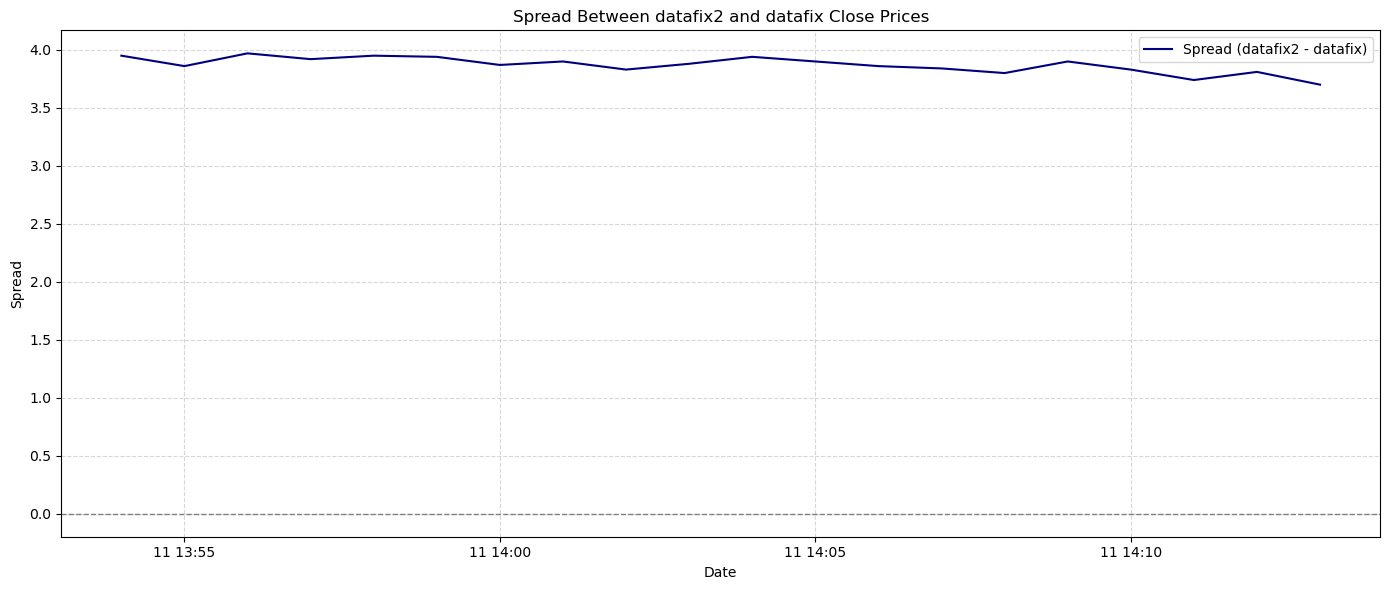

In [24]:
import matplotlib.pyplot as plt

# Calculate the spread
datafix["spread"] = datafix["Close"] - datafix2["Close"]

# Plot the spread
plt.figure(figsize=(14, 6))
plt.plot(datafix.index, datafix["spread"], label="Spread (datafix2 - datafix)", color='navy')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Spread Between datafix2 and datafix Close Prices")
plt.xlabel("Date")
plt.ylabel("Spread")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


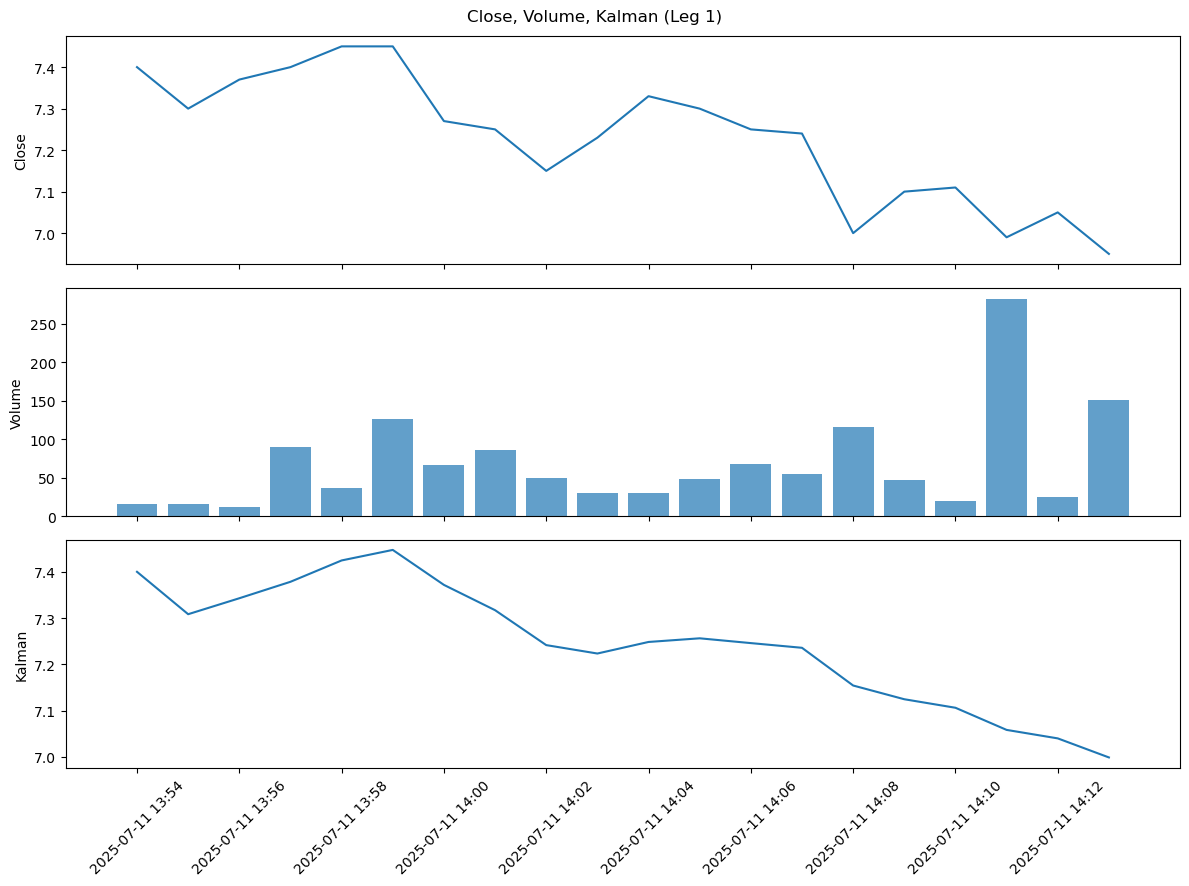

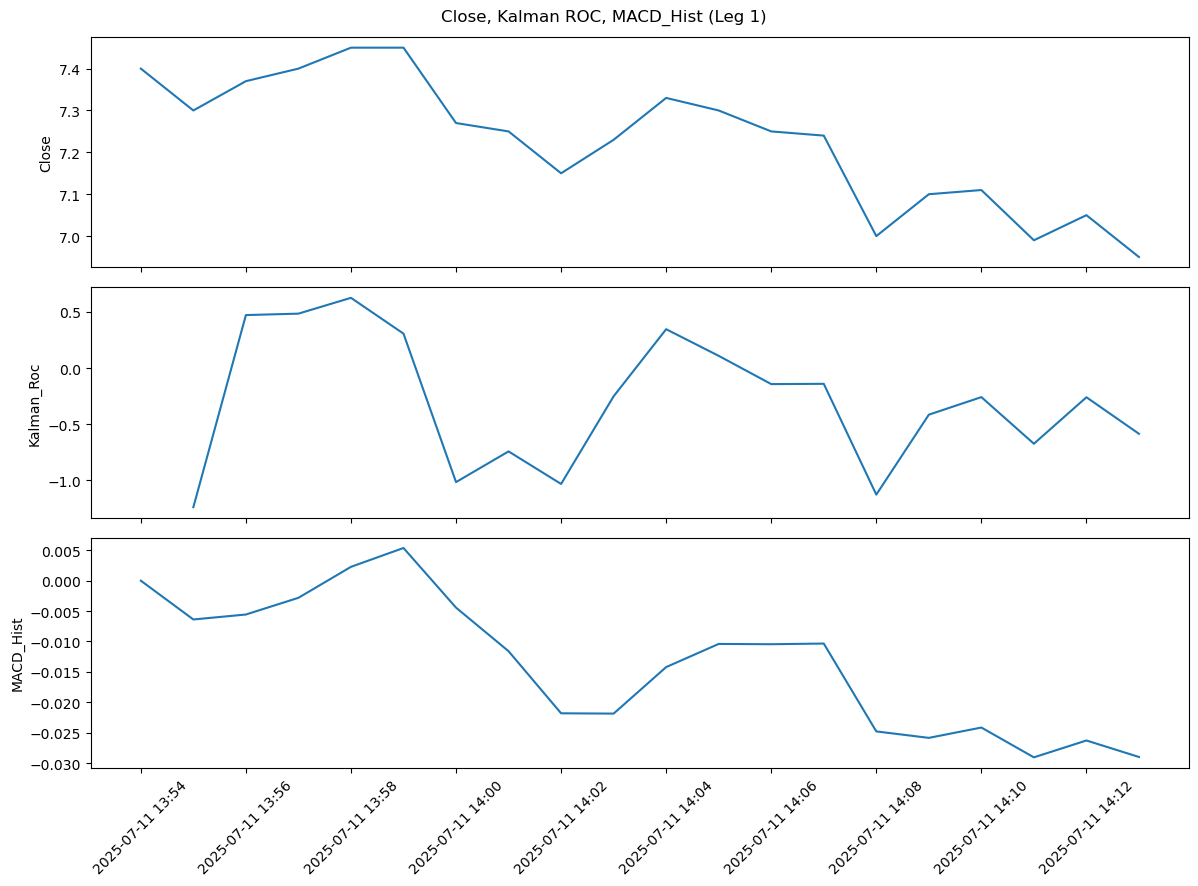

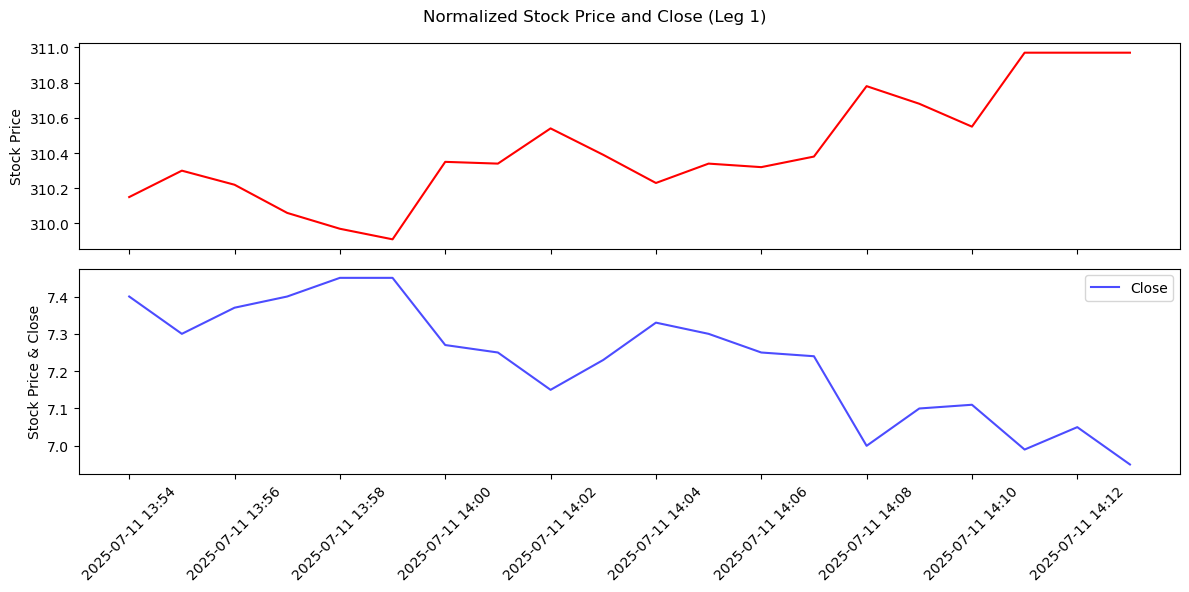

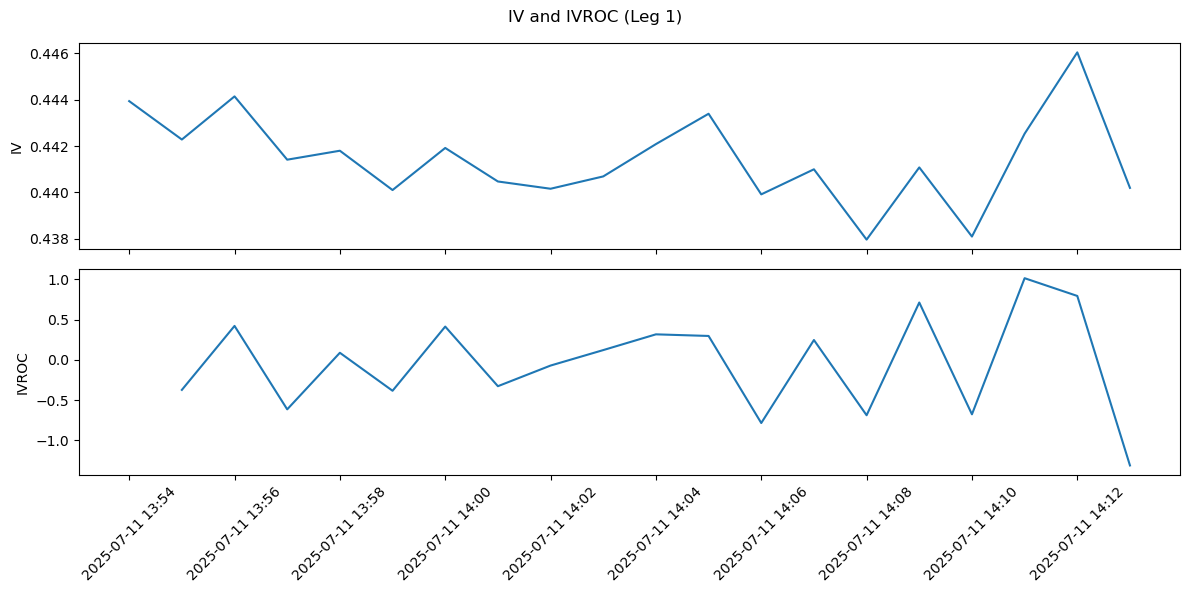

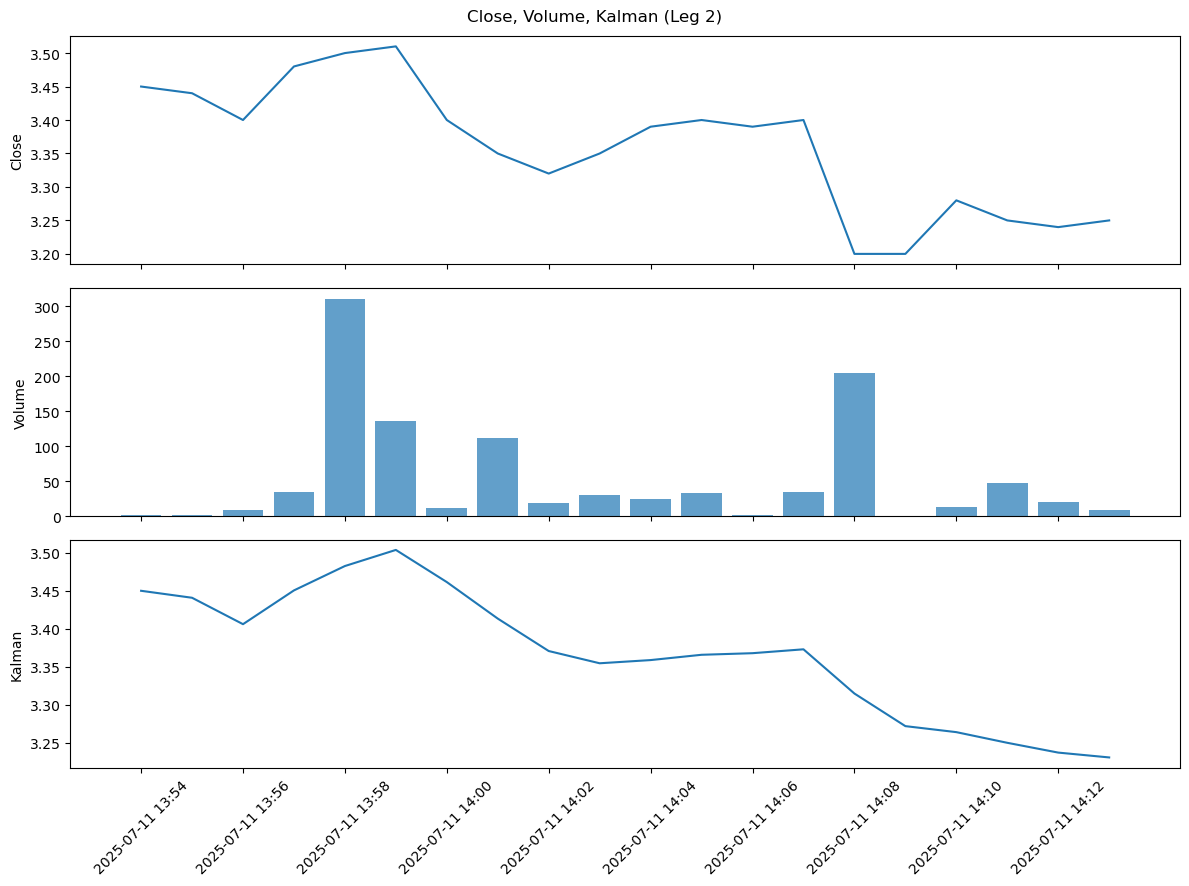

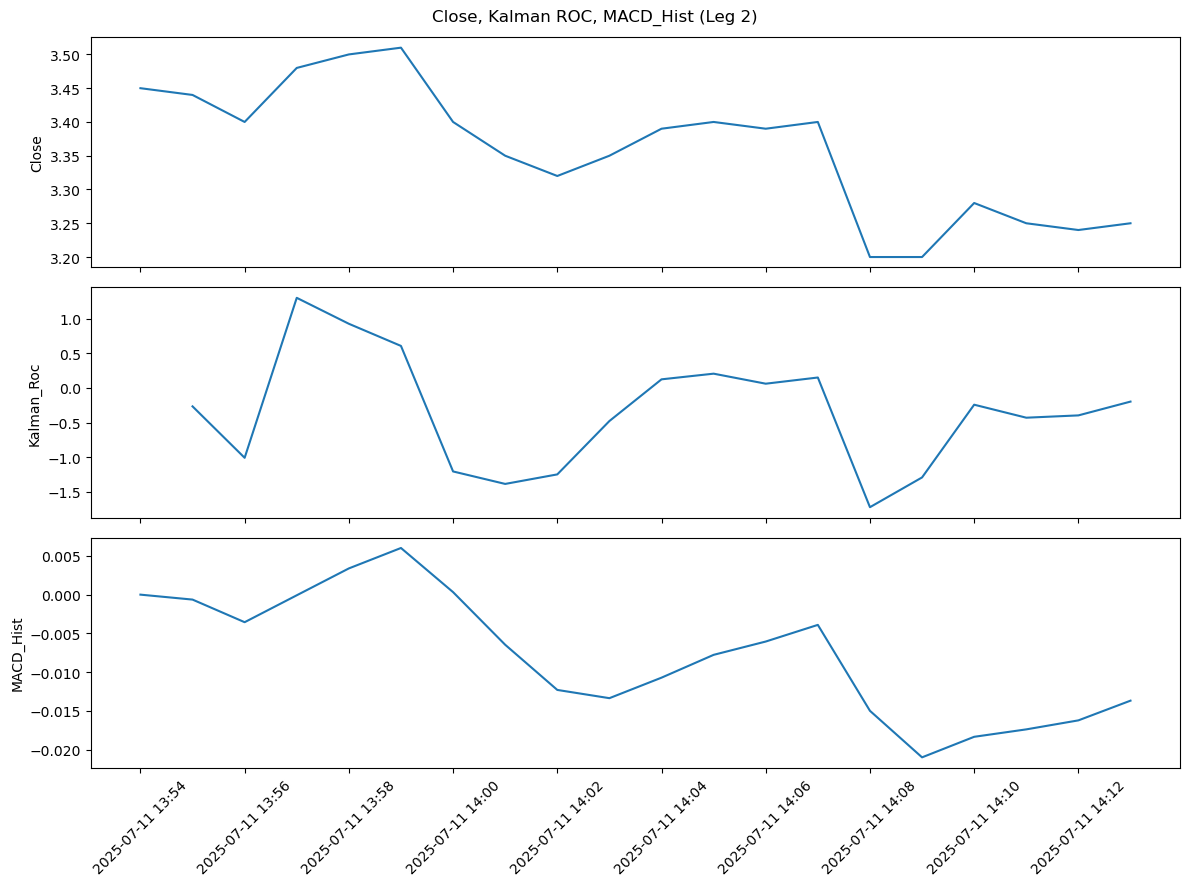

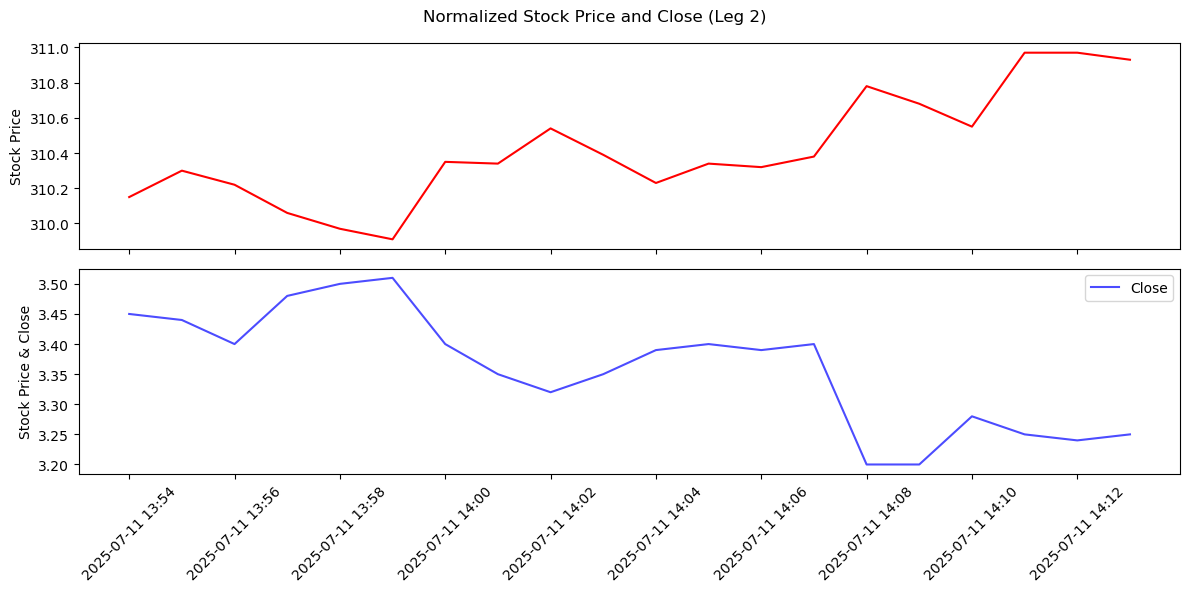

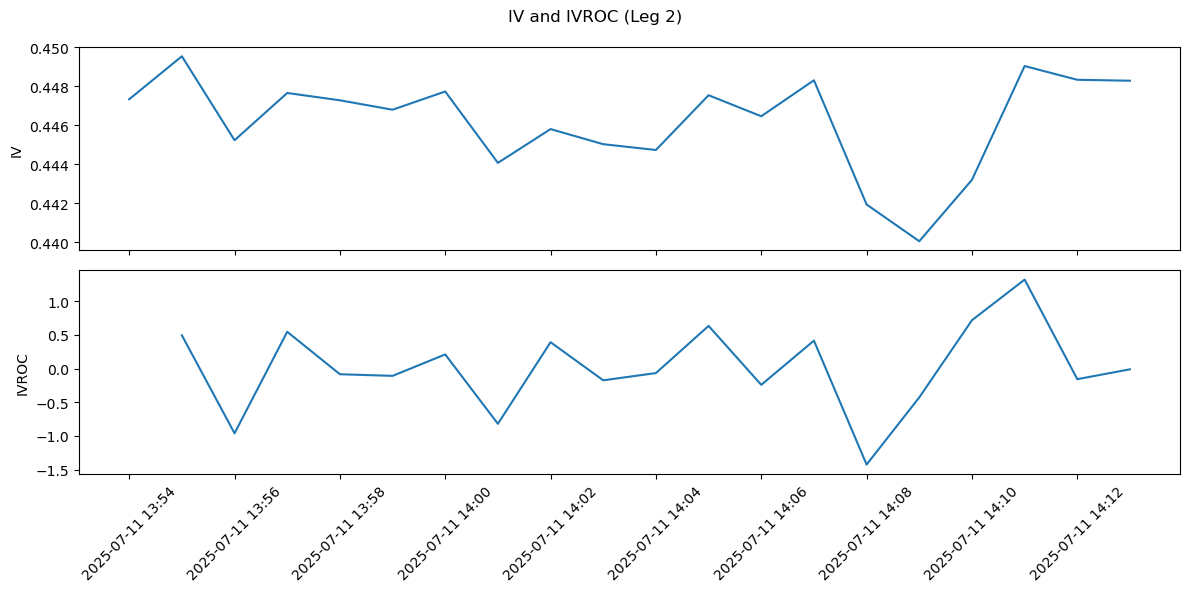

In [23]:
import matplotlib.pyplot as plt

def plot_leg(datafix, leg_label="Leg"):
    datafix_reset = datafix.reset_index()
    datetime_col = datafix_reset.columns[0]
    time_labels = datafix_reset[datetime_col]

    def plot_with_int_index(y_cols, suptitle, kinds=None):
        n = len(y_cols)
        fig, axs = plt.subplots(n, 1, figsize=(12, 3*n), sharex=True)
        if n == 1:
            axs = [axs]
        for i, col in enumerate(y_cols):
            kind = 'line' if not kinds else kinds[i]
            if kind == 'bar':
                axs[i].bar(datafix_reset.index, datafix_reset[col], label=col, alpha=0.7)
            else:
                axs[i].plot(datafix_reset.index, datafix_reset[col], label=col)
            axs[i].set_ylabel(col)
        step = max(1, len(time_labels) // 10)
        axs[-1].set_xticks(datafix_reset.index[::step])
        axs[-1].set_xticklabels([t.strftime('%Y-%m-%d %H:%M') for t in time_labels[::step]], rotation=45)
        plt.suptitle(f"{suptitle} ({leg_label})")
        plt.tight_layout()
        plt.show()

    # 1. Close, Volume (bar), Kalman
    plot_with_int_index(['Close', 'Volume', 'Kalman'], 'Close, Volume, Kalman', kinds=['line', 'bar', 'line'])

    # 2. Close, Kalman_Roc, MACD_Hist (bar)
    plot_with_int_index(['Close', 'Kalman_Roc', 'MACD_Hist'], 'Close, Kalman ROC, MACD_Hist', kinds=['line', 'line', 'line'])

    # 3. Overlay plot: normalized stock price and close
    fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    axs[0].plot(datafix_reset.index, datafix['Stock Price'], label='Stock Price', color='red')
    axs[0].set_ylabel('Stock Price')
    axs[1].plot(datafix_reset.index, datafix['Close'], label='Close', color='blue', alpha=0.7)
    axs[1].set_ylabel('Stock Price & Close')
    axs[1].legend()
    step = max(1, len(time_labels) // 10)
    axs[1].set_xticks(datafix_reset.index[::step])
    axs[1].set_xticklabels([t.strftime('%Y-%m-%d %H:%M') for t in time_labels[::step]], rotation=45)
    plt.suptitle(f'Normalized Stock Price and Close ({leg_label})')
    plt.tight_layout()
    plt.show()

    # 4. IV, IVROC
    plot_with_int_index(['IV', 'IVROC'], 'IV and IVROC')

# Plot for Leg 1
plot_leg(datafix, leg_label="Leg 1")

# Plot for Leg 2
plot_leg(datafix2, leg_label="Leg 2")
